In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import salem
import seaborn as sns
import statsmodels.api as sm
import swiss_uhi_utils as suhi
import xarray as xr
from scipy import stats
from pysal.lib import weights
from pysal.model import spreg
from rasterio import transform

from lausanne_greening_scenarios import utils

# Spatial regression

## 1. Read the input data

In [2]:
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
lulc_raster_filepath = '../data/processed/agglom-lulc.tif'
t_da_filepath = '../data/processed/tair-ucm.nc'

In [3]:
ls, ls_meta = utils.get_reclassif_landscape(
    lulc_raster_filepath, biophysical_table_filepath)

In [4]:
lulc_da = salem.open_xr_dataset(lulc_raster_filepath)['data']
t_da = suhi.align_ds(xr.open_dataarray(t_da_filepath), lulc_da)
hottest_day_da = t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax())
t_arr = hottest_day_da.values

## 2. Prepare the regression data frame

### 2.1 Features

#### 2.1.1 Landscape metrics

In [5]:
zone_pixel_width = 60
zone_pixel_height = 60

metrics = ['proportion_of_landscape', 'area_mn', 'shape_index_mn', 'edge_density']
class_val = utils.TREE_CLASS

In [6]:
zga = utils.get_zonal_grid_analysis(ls, ls_meta, zone_pixel_width=zone_pixel_width, zone_pixel_height=zone_pixel_height)
metrics_df = zga.compute_class_metrics_df(metrics=metrics, classes=[class_val]).apply(pd.to_numeric)
regr_df = metrics_df.iloc[metrics_df.index.get_level_values('class_val') == class_val].reset_index(drop=True)

#### 2.1.2 Distance to the city center

In [7]:
crs = zga.landscape_meta['crs']
p_center = gpd.GeoSeries([utils.BASE_MASK], crs=utils.BASE_MASK_CRS).to_crs(crs).iloc[0]
regr_df['dist_center'] = gpd.GeoSeries(gpd.points_from_xy(*transform.xy(zga.landscape_meta['transform'], *np.array(zga.zones).transpose())), crs=crs).apply(lambda p: p_center.distance(p))

#### 2.1.3 Elevation

### 2.2 Target

In [8]:
y_col = 'T'
regr_df[y_col] = np.nanmean(utils.get_zonal_grid_t_arrs(t_arr, zga), axis=(1, 2))

# drop rows with nan
regr_df_nonna = ~regr_df.isna().any(axis=1)
regr_df = regr_df.dropna()

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


## 3. Feature selection

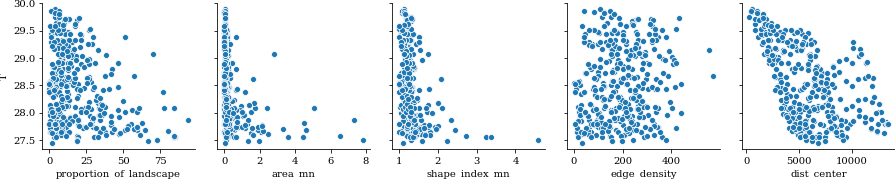

In [9]:
sns.pairplot(regr_df, x_vars=regr_df.columns.drop(y_col), y_vars=[y_col])

In [10]:
threshold = 2
w = weights.DistanceBand.from_array(np.array(zga.zones)[regr_df_nonna], threshold)

In [11]:
X = regr_df.drop(y_col, axis=1)
m = spreg.ML_Error(regr_df[y_col].values[:, None], X.values, w=w, name_y=y_col, name_x=list(X.columns))

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/scipy/optimize/_minimize.py:778: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/spreg/ml_error.py:485: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


In [13]:
print(m.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           T                Number of Observations:         358
Mean dependent var  :     28.5176                Number of Variables   :           6
S.D. dependent var  :      0.6725                Degrees of Freedom    :         352
Pseudo R-squared    :      0.3569
Sigma-square ML     :       0.022                Log likelihood        :     130.026
S.E of regression   :       0.150                Akaike info criterion :    -248.053
                                                 Schwarz criterion     :    -224.769

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [12]:
regr_df = regr_df.drop('area_mn', axis=1)

In [14]:
# X = regr_df.drop([y_col] + ['edge_density'], axis=1)
X = regr_df.drop(y_col, axis=1)
m = spreg.ML_Error(regr_df[y_col].values[:, None], X.values, w=w, name_y=y_col, name_x=list(X.columns))

In [15]:
print(m.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           T                Number of Observations:         358
Mean dependent var  :     28.5176                Number of Variables   :           5
S.D. dependent var  :      0.6725                Degrees of Freedom    :         353
Pseudo R-squared    :      0.3620
Sigma-square ML     :       0.027                Log likelihood        :      94.488
S.E of regression   :       0.164                Akaike info criterion :    -178.976
                                                 Schwarz criterion     :    -159.573

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

In [16]:
regr_df = regr_df.drop('edge_density', axis=1)

In [17]:
# X = regr_df.drop([y_col] + ['edge_density'], axis=1)
X = regr_df.drop(y_col, axis=1)
m = spreg.ML_Error(regr_df[y_col].values[:, None], X.values, w=w, name_y=y_col, name_x=list(X.columns))

In [18]:
print(m.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           T                Number of Observations:         358
Mean dependent var  :     28.5176                Number of Variables   :           4
S.D. dependent var  :      0.6725                Degrees of Freedom    :         354
Pseudo R-squared    :      0.3521
Sigma-square ML     :       0.027                Log likelihood        :      93.197
S.E of regression   :       0.165                Akaike info criterion :    -178.394
                                                 Schwarz criterion     :    -162.871

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

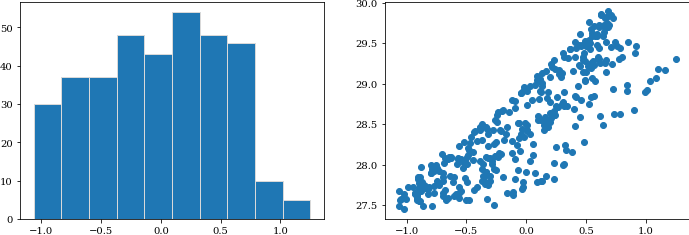

In [19]:
figwidth, figheight = plt.rcParams['figure.figsize']
fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
axes[0].hist(m.y - m.predy)
axes[1].scatter(m.y - m.predy, m.y)      

## 4. Partial regression

### 4.1 Using the a least squares regression

In [102]:
corr_df = pd.DataFrame(index=['r', 'p'])
for x_col in regr_df.drop(y_col, axis=1).columns:
    corr_df[x_col] = pg.partial_corr(data=regr_df, y=y_col, x=x_col, covar=list(regr_df.drop([x_col, y_col], axis=1).columns))[['r', 'p-val']].values.flatten()

In [103]:
corr_df

,proportion_of_landscape,shape_index_mn,dist_center
r,-3.087756e-01,-0.092155,-5.805483e-01
p,2.396770e-09,0.081639,1.215858e-33


### 4.2 Using the spatial regression

In [104]:
def get_spreg_ml_error_model(regr_df, y_col, w):
    X = regr_df.drop(y_col, axis=1)
    return spreg.ML_Error(regr_df[y_col].values[:, None],
                          X.values,
                          w=w,
                          name_y=y_col,
                          name_x=list(X.columns))

def get_partial_spreg_coeffs(regr_df, y_col, x_col, w, covar_col=None):
    # Based on https://gist.github.com/fabianp/9396204419c7b638d38f and
    # https://pingouin-stats.org/_modules/pingouin/correlation.html#partial_corr
    if isinstance(covar_col, str):
        covar_col = [covar_col]
    elif covar_col is None:
        covar_col = list(regr_df.columns.drop([y_col, x_col], errors='ignore'))
    # 1. perform a regression with x_col as target and covar as features
    m_x = get_spreg_ml_error_model(regr_df[covar_col + [x_col]], x_col, w)
    # 2. perform a regression with y_col as target and covar as features
    m_y = get_spreg_ml_error_model(regr_df[covar_col + [y_col]], y_col, w)
    # 3. return the correlation coefficient between the residuals of both
    # regressions
    return stats.pearsonr((m_x.y - m_x.predy).flatten(), (m_y.y - m_y.predy).flatten())

In [105]:
corr_df = pd.DataFrame(index=['r', 'p'])

for x_col in regr_df.drop(y_col, axis=1).columns:
    corr_df[x_col] = get_partial_spreg_coeffs(regr_df, y_col, x_col, w)

/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/scipy/optimize/_minimize.py:778: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)
/home/martibosch/anaconda3/envs/lausanne-greening-scenarios/lib/python3.7/site-packages/spreg/ml_error.py:485: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


In [106]:
corr_df

,proportion_of_landscape,shape_index_mn,dist_center
r,-3.299265e-01,-0.077047,-5.513871e-01
p,1.545916e-10,0.145708,7.295986e-30


## 5. Variance partitioning

In [20]:
def get_partial_explained_var(regr_df, y_col, feature_col, w):
    X = regr_df[feature_col]
    m = spreg.ML_Error(regr_df[y_col].values[:, None],
                       X.values,
                       w=w,
                       name_y=y_col,
                       name_x=feature_col)
    return m.pr2

In [21]:
groups = [
    ['proportion_of_landscape'],
    ['shape_index_mn']
]

all_features = [feature for group in groups for feature in group]
total_explained_var = get_partial_explained_var(regr_df, y_col, all_features, w)
group_explained_vars = [get_partial_explained_var(regr_df, y_col, group, w) for group in groups]
covs = np.linalg.solve(np.array([[1, 0, 1], [0, 1, 1], [1, 1, 1]]),
                       group_explained_vars + [total_explained_var])

In [30]:
covs

array([0.02535702, 0.02746524, 0.09036516])

In [90]:
corr_df

,proportion_of_landscape,shape_index_mn,dist_center
r,-3.299265e-01,-0.077047,-5.513871e-01
p,1.545916e-10,0.145708,7.295986e-30
